## Taksk 1
Create a function which calculates and returns the FIR filter **coefficients** analytically (= using **sinc** functions) for a **combined highpass and bandstop** filter. 
* The function should automatically decide how many coefficients are required. 
* The function arguments should be (a) the **sampling rate** and (b) the **cutoff frequencies**. 
* Decide which **cutoff frequencies** are needed and provide explanations by referring to the **spectra and/or fundamental frequencies** of the ECG

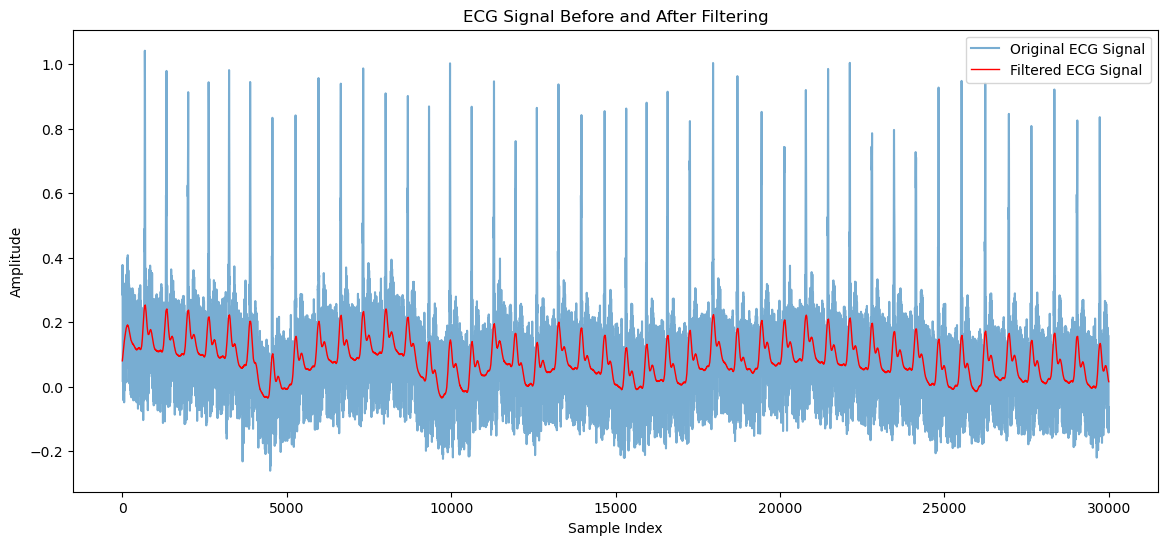

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def combined_highpass_bandstop_fir(sampling_rate, hp_cutoff=0.5, bs_center=50, bs_bandwidth=2):
    
    # Define Nyquist frequency and normalized cutoff
    nyquist = sampling_rate / 2
    normalized_hp_cutoff = hp_cutoff / nyquist
    
    # Calculate the high-pass filter order
    hp_transition_band = 0.5  # Example transition bandwidth
    hp_order = int(hp_transition_band / (normalized_hp_cutoff))  # Using Bt/N = (Ws - Wp) formula
    if hp_order % 2 == 0:  # Ensure order is odd for symmetry
        hp_order += 1
    highpass_coeffs = np.sinc(2 * normalized_hp_cutoff * (np.arange(hp_order) - (hp_order - 1) / 2))
    highpass_coeffs *= np.hamming(hp_order)
    highpass_coeffs = -highpass_coeffs
    highpass_coeffs[(hp_order - 1) // 2] += 1  # Make it a high-pass filter

    # Calculate the band-stop filter order
    bs_transition_band = 0.5  # Example transition bandwidth for the band-stop filter
    normalized_bs_low_cutoff = (bs_center - bs_bandwidth / 2) / nyquist
    normalized_bs_high_cutoff = (bs_center + bs_bandwidth / 2) / nyquist
    bs_order = int(bs_transition_band / (normalized_bs_high_cutoff - normalized_bs_low_cutoff))
    if bs_order % 2 == 0:
        bs_order += 1
    bandstop_coeffs = np.sinc(2 * normalized_bs_high_cutoff * (np.arange(bs_order) - (bs_order - 1) / 2)) \
                      - np.sinc(2 * normalized_bs_low_cutoff * (np.arange(bs_order) - (bs_order - 1) / 2))
    bandstop_coeffs *= np.hamming(bs_order)
    bandstop_coeffs[(bs_order - 1) // 2] += 1

    # Combine high-pass and band-stop filter coefficients by convolution
    combined_coeffs = np.convolve(highpass_coeffs, bandstop_coeffs)
    combined_coeffs /= np.sum(combined_coeffs)  # Normalize filter coefficients
    
    return combined_coeffs


def load_ecg_signal(filename, sampling_rate):
    try:
        ecg_signal = np.loadtxt(filename)
        return ecg_signal
    except ValueError:
        print('Error: Could not load file as text')
        return None
    
    

def apply_filter(ecg_signal, sampling_rate):
    fir_coeffs = combined_highpass_bandstop_fir(sampling_rate)  # Generate the FIR filter coefficients
    filtered_ecg_signal = np.convolve(ecg_signal, fir_coeffs, mode='same') # Apply the filter using convolution
    
    return filtered_ecg_signal

# Example usage
filename = 'ECG Traces-20241104/Noisy ECGs/Noisy_ECG_1000Hz_1.dat'  # Replace with your .dat file path
sampling_rate = 500  # Replace with your ECG signal sampling rate

# Load ECG signal data from file
ecg_signal = load_ecg_signal(filename, sampling_rate)

# Apply the combined filter
filtered_ecg_signal = apply_filter(ecg_signal, sampling_rate)

# Plot the original and filtered signals
plt.figure(figsize=(14, 6))
plt.plot(ecg_signal, label='Original ECG Signal', alpha=0.6)
plt.plot(filtered_ecg_signal, label='Filtered ECG Signal', color='red', linewidth=1)
plt.legend()
plt.title('ECG Signal Before and After Filtering')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()